In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score   
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from scipy.spatial.distance import pdist, squareform
from Bio import SeqIO
from scipy.cluster import hierarchy
import h5py
# vector graphics display (makes things less blurry)
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
###reading the data file

pdir = os.path.dirname(os.getcwd())

with np.load(os.path.join(pdir,"Protein_Data_Covariance" , "ohe_projection_matrices_truncated_512positions.npz")) as data:
    print("keys in file:")
    for k in data.keys():
        print(f"   {k}")
    total_number_of_proteins = data["total_number_of_proteins"].item()
    evals = data["evals"]
    V_512 = data["evecs_512"]

keys in file:
   total_number_of_proteins
   evals
   evecs_512


In [3]:
total_number_of_proteins

59374555

In [4]:
V_512.shape # features by components

(10752, 21504)

In [5]:
feature_names_512 = pd.read_csv(os.path.join( "/home" , "laragokcelioglu" , "codingprojects" , "Protein_Data_Covariance","feature_names_512positions.txt"), names=["feature_names"])
feature_names_256 = pd.read_csv(os.path.join("/home" , "laragokcelioglu" , "codingprojects","Protein_Data_Covariance", "feature_names_256positions.txt"), names=["feature_names"])
comp_names_256 = pd.read_csv(os.path.join("/home" , "laragokcelioglu" , "codingprojects","Protein_Data_Covariance", "principal_component_names.txt"), names=["comp_names"])
aminoacids_ordered = pd.read_csv(os.path.join("/home" , "laragokcelioglu" , "codingprojects","Protein_Data_Covariance", "sorted_amino_acids.txt"), names=["amino_acids"]).amino_acids.to_numpy().astype(str)

In [6]:
aminoacids_ordered

array(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M',
       'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*'], dtype='<U1')

In [7]:
# check that equality of the types is correct A == A
"A" == aminoacids_ordered[0]

True

In [8]:
ddir = os.getcwd()
df = pd.read_csv(os.path.join(ddir , "basic-monomeric.csv"), delimiter='\t')

In [9]:
# array of amino acids in a certain protein ( sirius aequorea victoria row(1) )
aminoacids = set(df.seq[0])   ###sets the aminoacids variable to the 1 row of seq column
aminoacids.add('*')
aminoacids = np.array(list(aminoacids))   ###turns the 1 line of seq column into a python list
aminoacids.sort()
aminoacids # all amino acids plus termination

array(['*', 'A', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'N', 'S', 'T', 'V',
       'W'], dtype='<U1')

In [10]:
### generating matrices
#                      add termination char        left justify    split all chars  to numpy array
leftjustified_seqs = (df.seq.astype(str) + "*").str.ljust(512, " ").apply(list).apply(np.array)
# vertically concatenate all proteins
leftjustified_seqs = np.vstack(leftjustified_seqs)

###left_justified_seqs are fixed to the size of 512 with this function
leftjustified_seqs

array([['E', 'L', 'S', ..., ' ', ' ', ' '],
       ['M', 'V', 'S', ..., ' ', ' ', ' '],
       ['M', 'A', 'G', ..., ' ', ' ', ' '],
       ...,
       ['M', 'A', 'S', ..., ' ', ' ', ' '],
       ['M', 'A', 'E', ..., ' ', ' ', ' '],
       ['M', 'A', 'E', ..., ' ', ' ', ' ']], dtype='<U1')

In [11]:
def match_aminoacids_ordered(protein_sequence, chars=aminoacids_ordered):
    """
    compares each pair of amino-acid at position in protein against
    our library of amino-acids (returns one hot)
    """
    return np.equal.outer(chars, protein_sequence).astype(np.float64)

In [12]:
protein_ohe = np.apply_along_axis(match_aminoacids_ordered, 1, leftjustified_seqs).reshape(leftjustified_seqs.shape[0], -1)

In [13]:
pdir # project dir
pdir = os.path.dirname(os.getcwd())

In [14]:
# read in file
df = pd.read_csv(os.path.join( "/home" , "laragokcelioglu" , "codingprojects","Protein_Data_Covariance", "basic-monomeric.csv"), sep="\t")

In [15]:
#                      add termination char        left justify    split all chars  to numpy array
leftjustified_seqs = (df.seq.astype(str) + "*").str.ljust(512, " ").apply(list).apply(np.array)
# vertically concatenate all proteins
leftjustified_seqs = np.vstack(leftjustified_seqs)

In [16]:
protein_ohe_ordered = np.apply_along_axis(match_aminoacids_ordered, 1, leftjustified_seqs)\
    .reshape(df.shape[0], -1)

In [17]:
df.seq[0]

'ELSKETALKKSFKFLVLIILWNNTVDAIHI'

In [18]:
# Confirm that our ohe features are in the correct locations to extract the correct feature names 
feature_names_512.feature_names[np.nonzero(protein_ohe_ordered[0, :])[0]].sort_values()

3072     001_E
5121     002_L
7682     003_S
5635     004_K
3076     005_E
8197     006_T
6        007_A
5127     008_L
5640     009_K
5641     010_K
7690     011_S
6667     012_F
5644     013_K
6669     014_F
5134     015_L
9743     016_V
5136     017_L
4625     018_I
4626     019_I
5139     020_L
8724     021_W
1045     022_N
1046     023_N
8215     024_T
9752     025_V
1561     026_D
26       027_A
4635     028_I
4124     029_H
4637     030_I
10270    031_*
Name: feature_names, dtype: object

In [19]:
protein_ohe_ordered.shape # proteins x features (512 position * 21 amino-acids)

(267, 10752)

In [20]:
V_512.shape

(10752, 21504)

In [21]:
proteins_projected_pc_coords = protein_ohe_ordered @ V_512

In [22]:
proteins_projected_pc_coords.shape # protein in same order as fpbase x principal component

(267, 21504)

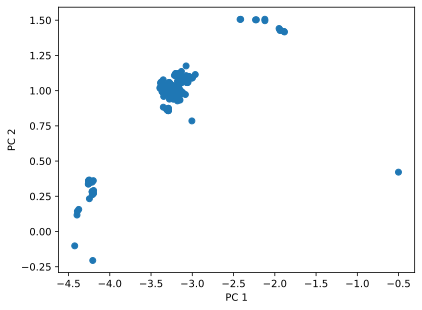

In [23]:
f, ax = plt.subplots()
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.scatter(proteins_projected_pc_coords[:,0], proteins_projected_pc_coords[:,1]);
plt.draw()

In [24]:
###Linear Regreesion Training

In [25]:
u, s, vt = np.linalg.svd(protein_ohe)
# matrix multiplication (this is just scaling each left singular vector, by it singular value) 
protein_projected_pc_coords = u @ np.diag(s)


In [26]:
# rows correspond to each protein in same order as 
protein_projected_pc_coords.shape



(267, 267)

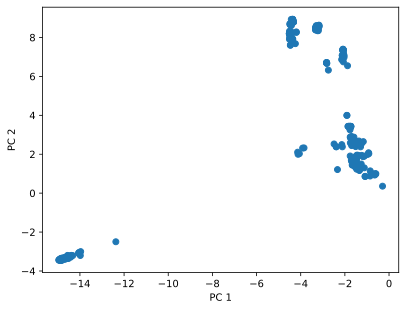

In [27]:
f, ax = plt.subplots()
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.scatter(protein_projected_pc_coords[:,0], protein_projected_pc_coords[:,1]);
plt.draw()

In [28]:
X = protein_projected_pc_coords
y = (df["ex_max"])

X.shape

(267, 267)

In [29]:
y.shape

(267,)

In [30]:
###setting up the k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf

KFold(n_splits=10, random_state=None, shuffle=False)

In [31]:
for train_index , test_index in kf.split(protein_projected_pc_coords):
      print(train_index ,test_index)

[ 27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266] [ 0  1  2  3  4  5  6  7 

In [32]:
import numpy as np
from sklearn.model_selection import KFold

X = protein_projected_pc_coords
y = (df["ex_max"])

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [ 27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266] TEST: [ 0  1  2  3

0.8508277720274428


Text(0.5, 1.0, "Predictions Of 'em_max' Using A Trained Model")

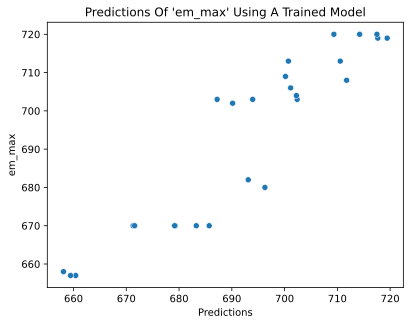

In [33]:
###predicting r2 value for test set

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
X = X_train
y = y_train
lasso = linear_model.Lasso()
lasso.fit(X_test,y_test)
y_pred = lasso.predict(X_test)
score = lasso.score(X_test, y_test)
print(score)

###plotting the predictions
sns.scatterplot(x=y_pred , y=y_test)
plt.xlabel("Predictions")
plt.ylabel("em_max")
plt.title("Predictions Of 'em_max' Using A Trained Model")

0.8915070823914895


Text(0.5, 1.0, "Predictions Of 'em_max' Using A Trained Model")

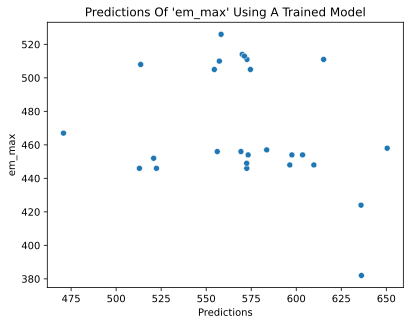

In [34]:
###predicting R2 for training set

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
X = X_train
y = y_train
y = y.fillna(0)

lasso = linear_model.Lasso()
lasso.fit(X,y)
y_pred = lasso.predict(X_test)
score = lasso.score(X,y)
print(score)

###plotting the predictions
sns.scatterplot(x=y_pred , y=y_train[:26])
plt.xlabel("Predictions")
plt.ylabel("em_max")
plt.title("Predictions Of 'em_max' Using A Trained Model")



In [35]:
from sklearn.metrics import mean_squared_error , mean_absolute_error
import math

###analytical analyis of the predictions vs real value
print("Mean Absolute Error: " , mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: " , mean_squared_error(y_test, y_pred))
print("RMSE: " , math.sqrt(mean_squared_error(y_test, y_pred)))



Mean Absolute Error:  120.94518624058429
Mean Squared Error:  17411.974153163694
RMSE:  131.954439687203


Text(0.5, 1.0, 'Residual Distribution')

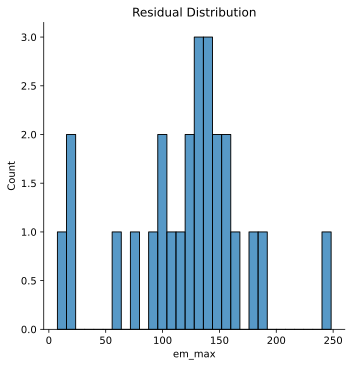

In [36]:
###residuals(errors)
residuals = y_test - y_pred
sns.displot(residuals, bins=30)
plt.title("Residual Distribution")

In [37]:
###checking for bias in residuals(errors)
import pylab
import scipy.stats as stats

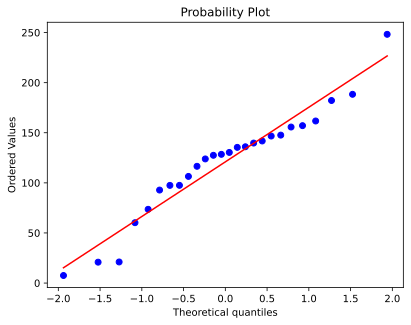

In [38]:
###plotting residuuals
stats.probplot(residuals , dist="norm", plot=pylab)
pylab.show()
